<a href="https://colab.research.google.com/github/RubenCrack/MasterIA_AprendizajeProfundo/blob/main/Evaluacion_Modulo_IA_RubenGarcia_Red_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)

# Evaluación de módulos I y II 
### Transfer Learning usando ResNet152V2
**Alumno :**

- Rubén Alejandro García Zegarra
---------------------------------------------------

In [25]:
#Variable de control para descarga del Dataset
COLAB = True

###Definición de librerias:


In [26]:
#Declarando librerias
from google.colab import drive
from google.colab import files
from glob import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from IPython.display import SVG, display, clear_output
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.applications import ResNet152V2
%matplotlib inline

###Descargando Dataset de pruebas

In [4]:
#Descarga del Dataset
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1el30soqoJ_OGiOwCki6g4Loez9r8aBBQ',
                                        dest_path='./DataSet.zip', unzip=True)

Unzipping...Done.


In [27]:
#Listando directorios
!ls

DataSet.zip  DataTest  DataTrain  DataVal  sample_data


###Preparar rutas de carpeta por cada set de datos

In [28]:
 #Cargando archivos de cada carpeta en arrays "
ficheros_train = glob("./DataTrain/coast/*jpg")
ficheros_val = glob("./DataVal/forest/*jpg")
ficheros_test = glob("./DataTest/highway/*jpg")

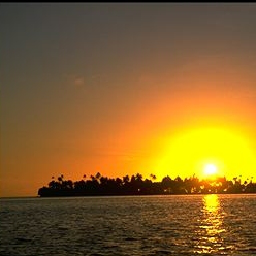

(256, 256, 3) 



In [29]:
##Mostrando imagen de ejemplo
imagen = load_img(ficheros_train[0])
display(imagen)
print(np.array(imagen).shape, "\n")

In [30]:
#Prepara carpetas para ser usadas en el entrenamiento
train_data_dir      = 'DataTrain'
validation_data_dir = 'DataVal'
test_data_dir       = 'DataTest'

###Red convolucional

Aplicando Feature Extraction con la red pre-entrenada: ResNet152V2

In [31]:
pre_trained_model = ResNet152V2(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

#Congelar capas superiores
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [32]:
#Recuperar capa de salida
modelFE = Sequential()
modelFE.add(pre_trained_model)
modelFE.add(Flatten())
modelFE.add(Dense(256, activation='relu'))
modelFE.add(Dense(8, activation='softmax'))
#modelFE.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])
#modelFE.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])
modelFE.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(), metrics=["accuracy"])


In [33]:
#Resumen del modelo
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 71,441,160
Trainable params: 13,109,512
Non-trainable params: 58,331,648
_________________________________________________________________


In [34]:
#Definir tamaño del batch size
batch_size = 16

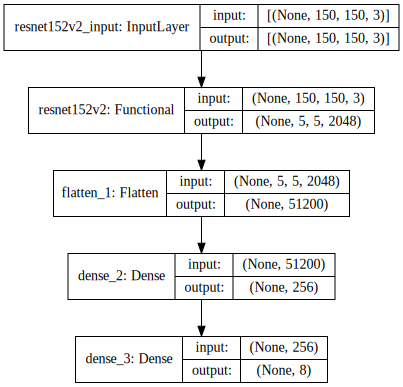

In [35]:
#Mostrar graficamente el Summary
display(SVG(model_to_dot(modelFE, show_shapes=True,dpi=72).create(prog='dot', format='svg')))

####Opciones para Data Aumentation:

In [36]:
#Preparando parámetros para Data aumentation
preprocess_input = lambda x:x/255.

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen   = ImageDataGenerator( rescale = 1.0/255. )

test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

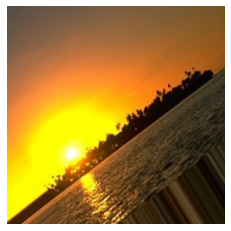

In [37]:
#Imagen de ejemplo:
imagen_num1 = np.expand_dims(np.array(imagen), axis=0)
plt.imshow(train_datagen.flow(imagen_num1)[0][0])
plt.axis("off");

####Entrenamos la red

In [38]:
#Definiendo los generadores de cada grupo de datos
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    #shuffle=True,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    #shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    #shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

Found 1882 images belonging to 8 classes.
Found 565 images belonging to 8 classes.
Found 241 images belonging to 8 classes.


In [39]:
#Entrenando la red
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFE = modelFE.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 50,
            validation_steps = validation_steps,
            verbose = 2)

Epoch 1/50
117/117 - 27s - loss: 3.6972 - accuracy: 0.7224 - val_loss: 0.6349 - val_accuracy: 0.8804
Epoch 2/50
117/117 - 17s - loss: 0.8532 - accuracy: 0.8339 - val_loss: 0.6172 - val_accuracy: 0.8875
Epoch 3/50
117/117 - 17s - loss: 0.8695 - accuracy: 0.8462 - val_loss: 0.4494 - val_accuracy: 0.8964
Epoch 4/50
117/117 - 17s - loss: 0.6173 - accuracy: 0.8639 - val_loss: 0.6917 - val_accuracy: 0.8964
Epoch 5/50
117/117 - 17s - loss: 0.6595 - accuracy: 0.8773 - val_loss: 0.5672 - val_accuracy: 0.8964
Epoch 6/50
117/117 - 17s - loss: 0.5695 - accuracy: 0.8842 - val_loss: 0.5630 - val_accuracy: 0.9071
Epoch 7/50
117/117 - 17s - loss: 0.4515 - accuracy: 0.9057 - val_loss: 0.6317 - val_accuracy: 0.9089
Epoch 8/50
117/117 - 17s - loss: 0.6703 - accuracy: 0.8896 - val_loss: 0.5772 - val_accuracy: 0.9161
Epoch 9/50
117/117 - 17s - loss: 0.5426 - accuracy: 0.9046 - val_loss: 0.5449 - val_accuracy: 0.9232
Epoch 10/50
117/117 - 17s - loss: 0.5008 - accuracy: 0.9051 - val_loss: 0.5492 - val_accura

In [41]:
#Obteniendo valor de precisión
test_lost, test_acc= modelFE.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

16/16 [==============================] - 1s 84ms/step - loss: 1.6829 - accuracy: 0.8921
Test Accuracy: 0.8921161890029907


<Figure size 432x288 with 0 Axes>

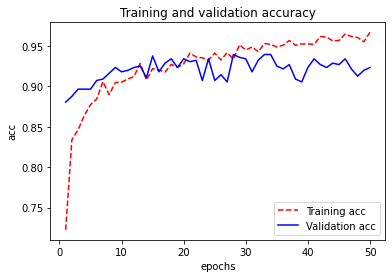

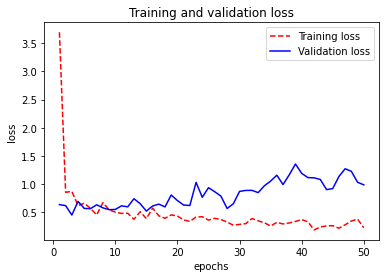

<Figure size 432x288 with 0 Axes>

In [42]:
#Graficando datos del entrenamiento
acc      = historyFE.history['accuracy' ]
val_acc  = historyFE.history['val_accuracy' ]
loss     = historyFE.history[    'loss' ]
val_loss = historyFE.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.ylim(0,1)

plt.legend()
plt.figure()

In [43]:
#Grabar modelo
modelpath="best_model_2.h5"
modelFE.save(modelpath)

In [44]:
#Verificamos archivo H5
!ls -la

total 453960
drwxr-xr-x  1 root root      4096 Mar  5 02:45 .
drwxr-xr-x  1 root root      4096 Mar  5 02:13 ..
-rw-r--r--  1 root root 339100296 Mar  5 02:45 best_model_2.h5
drwxr-xr-x  4 root root      4096 Mar  1 14:35 .config
-rw-r--r--  1 root root 125721697 Mar  5 02:17 DataSet.zip
drwxr-xr-x 10 root root      4096 Mar  5 02:17 DataTest
drwxr-xr-x 10 root root      4096 Mar  5 02:17 DataTrain
drwxr-xr-x 10 root root      4096 Mar  5 02:17 DataVal
drwxr-xr-x  1 root root      4096 Mar  1 14:35 sample_data


In [45]:
#Descargar el modelo a local:
files.download(modelpath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
#Recuperamos archivo del modelo
model = load_model(modelpath)
model

In [47]:
#Verificacion de indices de cada clase
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


## **Resultados obtenidos**

In [48]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

118/118 [==============================] - 17s 126ms/step - loss: 0.2108 - accuracy: 0.9649
Train loss    : 0.21082699298858643
Train accuracy: 0.9649309515953064

36/36 [==============================] - 4s 103ms/step - loss: 1.1420 - accuracy: 0.9221
Val loss    : 1.1420108079910278
Val accuracy: 0.922123908996582

16/16 [==============================] - 1s 84ms/step - loss: 1.6829 - accuracy: 0.8921
Test loss     : 1.6829442977905273
Test accuracy : 0.8921161890029907


## **Visualización de ejemplos de test**

In [54]:
#Preparando generador de imágenes
test_datagen2  = ImageDataGenerator( rescale = 1.0/255. )

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=test_generator.n,
    #shuffle=False,
    class_mode='sparse') #Sparse: entero a partir de 0. Categorical: one hot

Found 241 images belonging to 8 classes.


In [55]:
#Separando características y valor objetivo
test_generator2.reset()
X_te, y_te = test_generator2.next()
print(X_te.shape,y_te.shape)

(241, 150, 150, 3) (241,)


In [56]:
#Guarda clases
class_indices = test_generator2.class_indices
num3class = {test_generator2.class_indices[x]:x  for x in test_generator2.class_indices.keys()}

####Prueba de predicción: Ingresar un número de imágen entre 1 y 241

Introduce un numero entre 1 y 241, luego presione ENTER : 228
--------------------------------------------------------

Clase real: coast
-------------------------
Probabilidad: coast 100.00%               Probabilidad: tallbuilding 0.00%       
Probabilidad: street 0.00%                Probabilidad: opencountry 0.00%        
Probabilidad: mountain 0.00%              Probabilidad: insidecity 0.00%         
Probabilidad: highway 0.00%               Probabilidad: forest 0.00%             


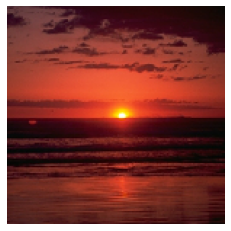

In [93]:
numero_img = int(input("Introduce un numero entre 1 y 241, luego presione ENTER : "))
print("--------------------------------------------------------")
print("")
if (numero_img<1 or numero_img>241):
  print("¡ El numero ingreso es inválido !")

#Ejemplo:
ind_te1 = numero_img
image3 = X_te[ind_te1].copy()
#print(image3)

print("Clase real:", num3class[y_te[ind_te1]])
plt.imshow(image3, cmap='jet')
plt.axis("off")

print("-------------------------")

lista1=[]

j=0
for i in num3class.keys():
  p = model.predict(np.expand_dims(image3, axis=0))[0][class_indices[num3class.get(i)]]
  linea_imprimir = "Probabilidad: " + num3class.get(i) + " {:2.2f}%".format(100*p)
  lista1.append([])
  lista1[j].append(100*p)
  lista1[j].append(linea_imprimir)
  j=j+1

lista2=sorted(lista1, reverse=True)

k=0
for i in range(4):
  print(lista2[k][1].ljust(39) + "   " + lista2[k+1][1].ljust(39))
  k=k+2